# Introduction to Keras

#### OHBM 2018 Education Course 

Anisha Keshavan


University of Washington


**Contact**: email: [anishakeshavan@gmail.com](mailto:anishakeshavan@gmail.com) , Twitter: [@akeshavan\_](https://twitter.com/akeshavan_)

## Set Up:

3 ways to set up:
    
1. If you have a Python environment set up on your computer: 
    
        git clone https://github.com/brainhack101/IntroDL
        cd IntroDL
        pip install -r requirements.txt
        jupyter notebook

2. Go to https://notebooks.azure.notebooks.com

3. Go to colaboratory

### How to use this notebook

* Hit Shift + Enter on your keyboard to run each cell

## What is Keras?

* Keras is a Python library for deep learning
* Under the hood, it uses Tensorflow
* Keras is more user friendly
* Extensive documentation is here: https://keras.io/

## Concepts in this Notebook

1. Loading and viewing data

2. Splitting data into training and testing sets

3. Layers: Convolutional, Fully Connected, Max Pooling

4. Optimizers

5. Loss functions

6. Fitting the model and viewing results

## Goal for this Tutorial

Our goal in this tutorial is to predict whether an image has an Anterior-Posterior flip. In large data collection studies, sometimes that coordinate space of images gets flipped, and we want to be able to quickly detect this inconsistency.

We will use Python and Keras to do the following:

1. [Load data](#1.-Loading-Data) from [IXI dataset](http://brain-development.org/ixi-dataset/)
2. [Visualize](#2.-Viewing-Data) the slices from our dataset
3. [Splitting Data](#3.-Split-data-into-a-training-and-testing-set) into a training and testing set
3. [Create Anterior-Posterior flipped data](#4.-Introducing-an-Anterior-Posterior-Flip) so that we can train our model to detect this
4. [Create the outcome variable](#5.-Creating-the-outcome-variable): this is what our model will predict
5. **[Build a model](#6.-Creating-a-Sequential-Model): Convolutional layers, max pooling, fully connected layers**
6. **[Fit our model](#7.-Fitting-the-Model): Epochs, batch size
7. **[Evaluate our model](#8.-Evaluating-the-model): Where did the model go wrong?**
8. [Conclusion](#9.-Conclusion)

# 1. Loading Data

Our data is stored as a **zip** file in the `sample_data` folder

#### Unzip the data

In [1]:
# if you're on collaboratory, UNCOMMENT THESE LINES and then run 

#!mkdir sample_data
#!wget https://s3-ap-southeast-1.amazonaws.com/ohbm2018/sample_data/IXI_small.zip -o sample_data/IXI_small.zip

In [ ]:
!unzip sample_data/IXI_small.zip -d sample_data/

#### Count the number of jpg files we have

The `glob` function in python will return a list of files that match our pattern

In [2]:
from glob import glob

image_files = glob('sample_data/*.jpg')
N = len(image_files)
print(N)

590


#### Import python libraries

In [44]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

#### Load JPG images into a numpy array

In [4]:
def load_image(filename):
    data_slice = plt.imread(filename)
    assert data_slice.shape == (256,256), "image file is not the right shape"
    return data_slice

In [86]:
# initialize an array that is the shape we need:

data_array = np.zeros((N, 256, 256, 1)) 
# the last dimension is the number of channels in the image.
# a grayscale image has 1 channel, while an RGB image has 3 channels (R,G,B).
# Could be MR modalities (channel1 = T1, channel2 = T2)

# iterate through all of the image files
for i, file in enumerate(image_files):
    # in Python, enumerate is a special function that gives us 
    # an index (i) and the item in the list (file)
    
    
    # load the file using our function
    data_slice = load_image(file)
    
    # put the data into our array, X
    data_array[i, :, :, 0] = data_slice

# 2. Viewing Data

Visualizing your data is important! Now that our data is in a 4D array, we will visualize a single slice:

In [87]:
def view_slice(data, index):
    plt.imshow(data[index,:,:,0],cmap=plt.cm.Greys_r)
    plt.axis('off');

View the first slice in our array (index=0)

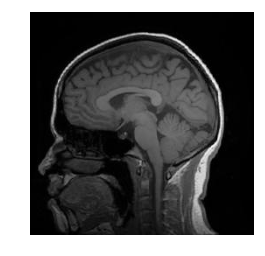

In [88]:
view_slice(data_array, 0)

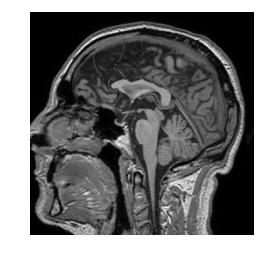

In [89]:
view_slice(data_array, 200)

# 3. Split data into a training and testing set

Its *really* important to do this. We need to make sure our model can generalize to new, unseen data. Here, we randomly shuffle our data, and reserve 80% of it for our training data, and the remaining 20% for testing.

In [90]:
np.random.seed(0) # set the random number generator seed, for consistency

indices = np.arange(N) # returns a 1D array, [0,1,...N-1]
np.random.shuffle(indices) # shuffles the indicies

# the first 80% of the data will be the training set.
N_80p = int(0.8 * N)
indices_train = indices[:N_80p]
X_train = data_array[indices_train,:,:,:]

# the last 20% of the data will be the testing set.

indices_test = indices[N_80p:]
X_test = data_array[indices_test,:,:,:]

print(X_train.shape, X_test.shape)

(472, 256, 256, 1) (118, 256, 256, 1)


# 4. Introducing an Anterior-Posterior Flip

Right now our training data has all the saggital slices pointing to the left. We want our model to detect orientation anomalies (e.g. if the orientation has flipped in the anterior-poster direction ). To do this, we generate another array of data that is purposely flipped. 

Indexing a python array with `::-1` reverses the order of the data. The third axis of our 4D array is the x-axis ordering, so we need to reverse the index there: 

In [91]:
X_train_flip = X_train[:, :, ::-1, :]
X_test_flip = X_test[:, :, ::-1, :]

Lets make sure we did this right:

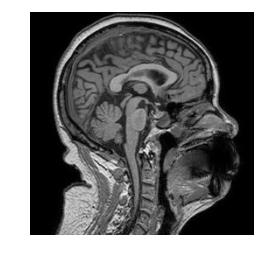

In [92]:
view_slice(X_train_flip, 100)

That looks good! 

#### Combine X and X_flip into 1 array

Now we will combine the original `X_train` and the flipped `X_train_flipped` into 1 array. And do the same with the test set

In [15]:
X_train = np.vstack((X_train, X_train_flip))
X_test = np.vstack((X_test, X_test_flip))

In [16]:
X_train.shape

(944, 256, 256, 1)

In [17]:
X_test.shape

(236, 256, 256, 1)

# 5. Creating the outcome variable

We need to define a variable that holds the outcome variable (1 or 0) that indicates whether or not the image is flipped. We know the first half of the X array corresponds to images that are the correct orientation, and the second half are not.

The steps we take here are:

1. Initialize an array of 0s that is the same length as X_train
2. Set the first half to 1

In [18]:
y_train_label = np.zeros(X_train.shape[0])

N_train_half = int(X_train.shape[0] / 2)
y_train_label[:N_train_half] = 1


y_test_label = np.zeros(X_test.shape[0])

N_test_half = int(X_test.shape[0] / 2)
y_test_label[:N_test_half] = 1

We need to reformat the shape of our outcome variables, `y_train` and `y_test`, because Keras needs the labels as a 2D array. Keras provides a function to do this:

In [75]:
from keras.utils import to_categorical

In [20]:
y_train = to_categorical(y_train_label)
y_test = to_categorical(y_test_label)

In [21]:
y_train

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

Shuffle the training data so that the samples aren't grouped

In [22]:
shuffled_train_indices = np.arange(2*N_train_half)
np.random.shuffle(shuffled_train_indices)

X_train = X_train[shuffled_train_indices, :,:,:]
y_train = y_train[shuffled_train_indices, :]

In [23]:
print(X_train.shape, y_train.shape)

(944, 256, 256, 1) (944, 2)


In [24]:
y_train

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]])

# 6. Creating a Sequential Model

import the necessary functions from the Keras library

In [77]:
import tensorflow as tf
tf.device('cpu')
from keras.models import Sequential

from keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D

from keras.optimizers import Adam, SGD

from keras import backend as K
K.clear_session()

In [80]:
kernel_size = (3, 3)
n_classes = 2

filters = 8

model = Sequential()

model.add(Conv2D(filters, kernel_size, activation='relu', input_shape=(256, 256, 1)))

model.add(BatchNormalization())

model.add(MaxPooling2D())
model.add(Conv2D(filters*2, kernel_size, activation='relu'))

model.add(MaxPooling2D())
model.add(Conv2D(filters*4, kernel_size, activation='relu'))

model.add(MaxPooling2D())
model.add(Conv2D(filters*8, kernel_size, activation='relu'))

model.add(MaxPooling2D())
model.add(Conv2D(filters*16, kernel_size, activation='relu'))

model.add(MaxPooling2D())
model.add(Conv2D(filters*32, kernel_size, activation='relu'))

model.add(MaxPooling2D())
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(n_classes, activation='softmax'))

learning_rate = 1e-5
adam = Adam(lr=learning_rate)
sgd = SGD(lr=learning_rate)


model.compile(loss='categorical_crossentropy',
                 optimizer=adam, # swap out for sgd 
                 metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 254, 254, 8)       80        
_________________________________________________________________
batch_normalization_2 (Batch (None, 254, 254, 8)       32        
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 127, 127, 8)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 125, 125, 16)      1168      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 60, 60, 32)        4640      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 30, 30, 32)        0         
__________

# 7. Fitting the Model

In [81]:
fit = model.fit(X_train, y_train, epochs=5, batch_size=2)

Epoch 1/5
944/944 [==============================] - 43s 46ms/step - loss: 0.5585 - acc: 0.7087
Epoch 2/5
944/944 [==============================] - 42s 44ms/step - loss: 0.3605 - acc: 0.8506
Epoch 3/5
944/944 [==============================] - 44s 47ms/step - loss: 0.2371 - acc: 0.9227
Epoch 4/5
944/944 [==============================] - 46s 49ms/step - loss: 0.1543 - acc: 0.9439
Epoch 5/5
944/944 [==============================] - 42s 44ms/step - loss: 0.1135 - acc: 0.9640


In [66]:
def get_figure():
    """
    Returns figure and axis objects to plot on. 
    Removes top and right border and ticks, because those are ugly
    """
    fig, ax = plt.subplots(1)
    plt.tick_params(top='off', right='off', which='both') 
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return fig, ax

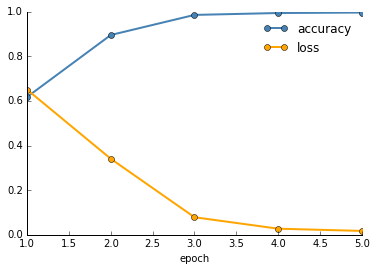

In [67]:
fig, ax = get_figure()

epoch = np.arange(5) + 1
ax.plot(epoch, fit.history['acc'], marker="o", linewidth=2, color="steelblue", label="accuracy")
ax.plot(epoch, fit.history['loss'], marker="o", linewidth=2, color="orange", label="loss")
ax.set_xlabel('epoch')
ax.legend(frameon=False);

# 8. Evaluating the model

In [30]:
model.evaluate(X_test, y_test)

236/236 [==============================] - 3s 15ms/step


[0.006655063954340067, 0.9957627118644068]

#### What did it mess up on?

In [31]:
y_pred = model.predict(X_test)

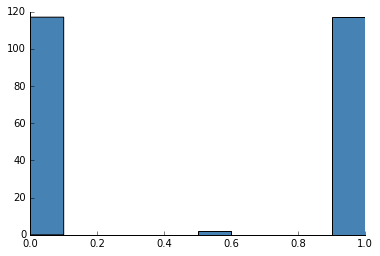

In [71]:
fig, ax = get_figure()
ax.hist(y_pred[:,0], color="steelblue");

In [32]:
np.nonzero(np.isclose(y_test[:,0], y_pred[:,0], atol=1e-1) == False)

(array([ 47, 165]),)

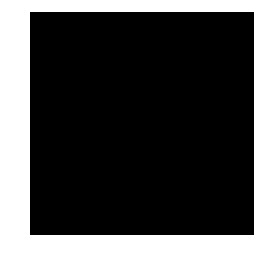

In [72]:
view_slice(X_test, 47)

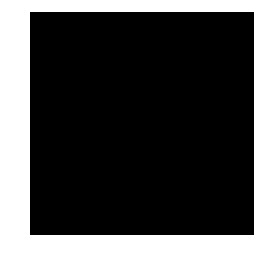

In [73]:
view_slice(X_test, 165)

#### What about the training set?

In [46]:
y_train_pred = model.predict(X_train)

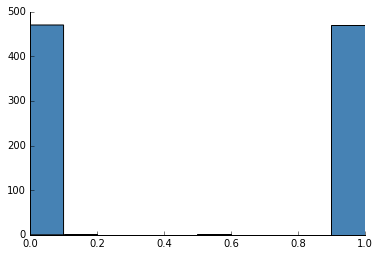

In [70]:
fig, ax = get_figure()
ax.hist(y_train_pred[:,0], color="steelblue");

In [48]:
np.nonzero(np.isclose(y_train[:,0], y_train_pred[:,0], atol=1e-1) == False)

(array([641, 661, 828]),)

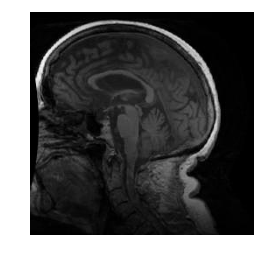

In [50]:
view_slice(X_train, 641)

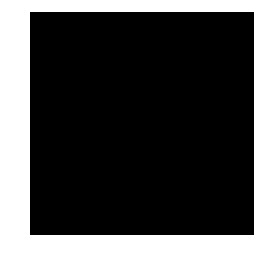

In [51]:
view_slice(X_train, 661)

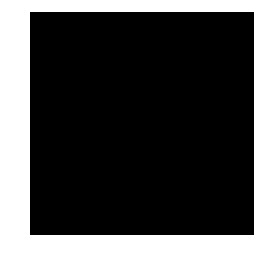

In [52]:
view_slice(X_train, 828)

# 9. Conclusion